In [135]:
from google.cloud import bigquery
import pandas as pd
import google
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# Establece la variable de entorno GOOGLE_APPLICATION_CREDENTIALS con la ruta al archivo de credenciales
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/raul.raggio/AppData/Roaming/gcloud/application_default_credentials.json"
credentials, project = google.auth.default()


project="peya-chile"


client = bigquery.Client(project=project, credentials=credentials)
print("Client creating using default project: {}".format(client.project))

Client creating using default project: peya-chile


c:\Users\raul.raggio\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [136]:
#parámetros fase 1
country="chile"

fecha_inferior="2025-01-27"
fecha_superior="2025-03-02"
semanas_fin_de_mes=["2025-01-27"]

percentil_franchise=0.8
pecentil_cuisine=0.8
minimo_semanas_tendencia=3


pendiente_tendencia_ept_atvc=0.35
pendiente_tendencia_atvc=-0.05

minimo_orders_semana=30
minimo_orders_partner=60
vendor_late_min=0.15



per_limite=1.1



In [137]:
flag=1

In [138]:

if flag ==0:
    
    sql1 = f"""


SELECT
    logistic_orders.country.country_name  AS logistic_orders_country__country_name,
        (FORMAT_DATE('%F', DATE_TRUNC(logistic_orders.created_date_local , WEEK(MONDAY)))) AS logistic_orders_created_date_local_week,
(logistic_orders.created_date_local ) AS logistic_orders_created_date_local_date,
        
    dim_partner.partner_name  AS dim_partner_partner_name,
    dim_partner.partner_id  AS dim_partner_partner_id,
    dim_partner.warehouse_name,
    dim_partner.warehouse_id,
    dim_partner.business_type.business_type_name,
    dim_partner.main_cousine_category_name as cuisine,
    logistic_orders.city.city_name as city,

    
    (EXTRACT(HOUR FROM logistic_orders.created_at_local )) AS logistic_orders_created_at_local_hour_of_day,

    
    (FORMAT_DATE('%A', logistic_orders.created_date_local )) AS logistic_orders_created_date_local_day_of_week,
    dim_partner.franchise.franchise_name as franchise_name,

CAST( SUM(logistic_orders.timings.vendor_late/60)/ Nullif((COUNT(DISTINCT CASE WHEN  logistic_orders.timings.vendor_late/60  IS NOT NULL THEN  logistic_orders.order_sk   ELSE NULL end )),0 ) as FLOAT64) as avg_vendorlate
    ,

CAST(sum( logistic_orders.is_vendor_late_10)/ Nullif(sum( logistic_orders.is_vendor_late_nn),0) AS FLOAT64) as logistic_orders_kpi_percentage_vendor_late_10,

 Nullif(sum( logistic_orders.is_vendor_late_10),0) as is_vendor_late_10,

Nullif(sum( logistic_orders.is_vendor_late_nn),0) as is_vendor_late_nn,
    Nullif(sum( logistic_orders.is_rider_late_10),0) as is_rider_late_10,

Nullif(sum( logistic_orders.is_rider_late_nn),0) as is_rider_late_nn,


CAST(sum(logistic_orders.estimated_prep_time/60) AS FLOAT64) as sum_estimated_prep_time,
COUNT(DISTINCT CASE WHEN   logistic_orders.estimated_prep_time  IS NOT NULL THEN  logistic_orders.order_sk   ELSE NULL END) as orders_estimated_prep_time,

    COUNT(DISTINCT CASE WHEN (UPPER(( CASE WHEN ( logistic_orders.timings.actual_delivery_time*1.000/60  ) > 45 THEN 'Slow Delivery' ELSE 'No Slow Delivery' END
 )) = UPPER('Slow Delivery')) THEN logistic_orders.order_sk  ELSE NULL END) AS orders_slow_delivery,

    COUNT(DISTINCT logistic_orders.order_sk ) AS Orders, 
  
 COUNT(DISTINCT CASE WHEN ( fact_orders.promisedDeliveryTime.maxMinutes   + 10) < ( logistic_orders.timings.actual_delivery_time*1.000/60  )  THEN logistic_orders.order_sk  ELSE NULL END) AS orders_lcf,
 
 CAST(  SUM( logistic_orders.timings.at_vendor_time_cleaned/60)as FLOAT64) AS sum_at_vendor_time_cleaned,
  COUNT(DISTINCT CASE WHEN   logistic_orders.timings.at_vendor_time_cleaned  IS NOT NULL THEN  logistic_orders.order_sk   ELSE NULL END) as orders_at_vendor_cleaned,
    
 CAST(sum(logistic_orders.timings.assumed_actual_preparation_time/60)AS FLOAT64) as sum_assumed_prep_time,
 COUNT(DISTINCT CASE WHEN   logistic_orders.timings.assumed_actual_preparation_time IS NOT NULL THEN  logistic_orders.order_sk   ELSE NULL END) as orders_assumed_prep_time
   
   
   
FROM `peya-bi-tools-pro.il_logistics.fact_logistic_orders` AS logistic_orders
LEFT JOIN `peya-bi-tools-pro.il_core.fact_orders`  AS fact_orders ON fact_orders.order_id= logistic_orders.peya_order_id and fact_orders.registered_date = logistic_orders.created_date_local

LEFT JOIN `peya-bi-tools-pro.il_core.dim_partner` AS dim_partner ON dim_partner.partner_id=fact_orders.restaurant.id

WHERE ( ( logistic_orders.created_date_local  ) between  DATE('{fecha_inferior}') AND DATE(current_date() ))

AND UPPER( logistic_orders.country.country_name  ) = UPPER('{country}')
AND (NOT (logistic_orders.is_preorder ) OR (logistic_orders.is_preorder ) IS NULL)

 AND ((fact_orders.restaurant.id ) > 0 OR (fact_orders.restaurant.id ) IS NULL) 
 AND (logistic_orders.peya_order_id ) IS NOT NULL
GROUP BY 1, 2, 3, 4,5,6,7,8,9,10,11,12,13
ORDER BY 12 DESC

    """
    data1=client.query(sql1).to_dataframe()
    data1.to_csv("data1.csv")
else:
    
    data1=pd.read_csv("data1.csv")

In [139]:
df1=data1
df1['Orders'] = df1['Orders'].astype(str).str.replace(',', '').astype(float)
df1['orders_slow_delivery'] = df1['orders_slow_delivery'].astype(str).str.replace(',', '').astype(float)
df1['warehouse_name'].fillna("no warehouse", inplace=True)

df1['logistic_orders_created_date_local_date'] = pd.to_datetime(df1['logistic_orders_created_date_local_date'])
df1['% slow delivery']=100*df1['orders_slow_delivery']/df1['Orders']
df1['dim_partner_partner_name'] = df1['dim_partner_partner_name'].str.lower()
df1['cuisine'].fillna("no-cuisine", inplace=True)

df1['business_type_name'].fillna("no vertical", inplace=True)



df1['franchise_name'].fillna("no franchise", inplace=True)
df1['city'].fillna("city", inplace=True)
df1['franchise_name'] = df1['franchise_name'].str.lower()
df1['cuisine'] = df1['cuisine'].str.lower()

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\193169440.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['warehouse_name'].fillna("no warehouse", inplace=True)
C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\193169440.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [140]:
    

def asignar_tipo_dia(dia):
    if dia in ['Friday', 'Saturday', 'Sunday']:
        return 'FRIDAY-SUNDAY'
    else:
        return 'MONDAY-THURSDAY'

def asignar_horario(hora):
    if hora<=11:
        return '0-11'
    elif hora<=14:
        return '12-14'
    elif hora<=17:
        return '15-17'
    elif hora<=20:
        return '18-20'
    else:
        return '21-23'
    
df1['dia'] = df1["logistic_orders_created_date_local_day_of_week"].apply(asignar_tipo_dia)  

df1['horario'] = df1["logistic_orders_created_at_local_hour_of_day"].apply(asignar_horario)  



In [141]:
datamall=pd.read_csv("base mall (2).csv")
datamall=datamall[["Partner_id","Mall"]]
df1 = pd.merge(df1, datamall, how='left', left_on='dim_partner_partner_id', right_on='Partner_id')

# Crear la nueva columna "mall" en df1
df1['mall'] = df1['Partner_id'].apply(lambda x: 1 if pd.notna(x) else 0)
df1['Partner_id'].fillna(0, inplace=True)
df1['Mall'].fillna("No Mall", inplace=True)
df1

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\2459100889.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Partner_id'].fillna(0, inplace=True)
C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\2459100889.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

,Unnamed: 0,logistic_orders_country__country_name,logistic_orders_created_date_local_week,logistic_orders_created_date_local_date,dim_partner_partner_name,dim_partner_partner_id,warehouse_name,warehouse_id,business_type_name,cuisine,...,sum_at_vendor_time_cleaned,orders_at_vendor_cleaned,sum_assumed_prep_time,orders_assumed_prep_time,% slow delivery,dia,horario,Partner_id,Mall,mall
0,0,Chile,2025-03-03,2025-03-05,star burger.,364058.0,no warehouse,NaN,Restaurant,hamburguesas,...,2.566667,2,42.983333,2,0.0,MONDAY-THURSDAY,15-17,0.0,No Mall,0
1,1,Chile,2025-02-03,2025-02-05,la joyita burgers,58848.0,no warehouse,NaN,Restaurant,hamburguesas,...,0.000000,1,NaN,0,0.0,MONDAY-THURSDAY,21-23,0.0,No Mall,0
2,2,Chile,2025-02-10,2025-02-12,fan del sándwich,66844.0,no warehouse,NaN,Restaurant,sándwiches,...,0.000000,1,8.133333,1,0.0,MONDAY-THURSDAY,15-17,0.0,No Mall,0
3,3,Chile,2025-02-10,2025-02-12,dunkin' consistorial,199003.0,no warehouse,NaN,Restaurant,cafetería,...,0.000000,2,8.916667,1,0.0,MONDAY-THURSDAY,15-17,0.0,No Mall,0
4,4,Chile,2025-01-27,2025-01-29,street wrap concon,224824.0,no warehouse,NaN,Restaurant,wraps,...,12.683333,1,36.716667,1,100.0,MONDAY-THURSDAY,18-20,0.0,No Mall,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392368,1392368,Chile,2025-02-03,2025-02-07,kfc teniente cruz,484231.0,no warehouse,NaN,Restaurant,pollo frito,...,3.650000,3,31.750000,2,0.0,FRIDAY-SUNDAY,15-17,0.0,No Mall,0
1392369,1392369,Chile,2025-02-24,2025-02-28,ahorra food depot - vitacura,526663.0,no warehouse,NaN,Market,no-cuisine,...,0.000000,1,10.083333,1,0.0,FRIDAY-SUNDAY,0-11,0.0,No Mall,0
1392370,1392370,Chile,2025-02-10,2025-02-14,petrobras - ciudad satélite,103600.0,no warehouse,NaN,Market,no-cuisine,...,6.216667,3,9.250000,2,0.0,FRIDAY-SUNDAY,12-14,0.0,No Mall,0
1392371,1392371,Chile,2025-02-03,2025-02-07,farmacia ahumada 346 - antofagasta,472774.0,no warehouse,NaN,Pharmacy,no-cuisine,...,20.416667,2,NaN,0,100.0,FRIDAY-SUNDAY,12-14,0.0,No Mall,0


In [142]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] )) & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior)  & (df1["logistic_orders_created_date_local_date"]<=fecha_superior)]
grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','franchise_name','cuisine']).agg({'sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})


grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped)
prueba=prueba.reset_index()

dfaux=prueba
franchise_limits = dfaux.groupby(['franchise_name']).agg({'avg_estimated_prep_time': lambda x: np.percentile(x, 80), 'Orders': 'sum' }).reset_index()
franchise_limits=franchise_limits.sort_values(by="Orders",ascending=False) 
franchise_limits=franchise_limits[["franchise_name","avg_estimated_prep_time"]]
franchise_limits["avg_estimated_prep_time"]=round(franchise_limits["avg_estimated_prep_time"]-1)
franchise_limits=franchise_limits[(franchise_limits["avg_estimated_prep_time"]>0) & (franchise_limits["avg_estimated_prep_time"]<=60)& (franchise_limits["franchise_name"]!="no franchise")]
franchise_limits.columns=["franchise_name","Limite de Prep Time Franchise"]

dfaux=prueba
cuisine_limits = dfaux.groupby(['cuisine']).agg({'avg_estimated_prep_time': lambda x: np.percentile(x, 80)}).reset_index()
cuisine_limits["avg_estimated_prep_time"]=round(cuisine_limits["avg_estimated_prep_time"]-1)
cuisine_limits=cuisine_limits[(cuisine_limits["avg_estimated_prep_time"]>0) & (cuisine_limits["avg_estimated_prep_time"]<=60)& (cuisine_limits["cuisine"]!="no franchise")]
cuisine_limits.columns=["cuisine","Limite de Prep Time Cuisine"]

cuisine_limits

,cuisine,Limite de Prep Time Cuisine
0,cafetería,14.0
1,carnes,22.0
2,comida asiática,20.0
3,comida casera,19.0
4,comida china,15.0
5,comida india,19.0
6,comida mexicana,20.0
7,comida peruana,21.0
8,comida vegana,21.0
9,comida vegetariana,21.0


In [143]:
#reemplazos manuales

cuisine_limits.loc[cuisine_limits['cuisine'] == 'sushi', 'Limite de Prep Time Cuisine'] = 40
cuisine_limits.loc[cuisine_limits['cuisine'] == 'comida japonesa', 'Limite de Prep Time Cuisine'] = 40

franchise_limits.loc[franchise_limits['franchise_name'] == 'under pizzas', 'Limite de Prep Time Franchise'] = 30
franchise_limits.loc[franchise_limits['franchise_name'] == 'doggis', 'Limite de Prep Time Franchise'] = 20


In [144]:
franchise_limits[:20]
# ver donde esta el limite de prep time, percentil 100 mediana etc 

,franchise_name,Limite de Prep Time Franchise
230,mcdonald's,16.0
264,papa john's,24.0
181,kfc,15.0
46,burger king,15.0
351,tarragona,13.0
233,melt pizzas,28.0
209,little caesar's,14.0
110,dunkin donuts,14.0
373,under pizzas,30.0
253,niu,46.0


In [145]:
df1 = pd.merge(df1, franchise_limits, how='left', left_on='franchise_name', right_on='franchise_name')
df1 = pd.merge(df1, cuisine_limits, how='left', left_on='cuisine', right_on='cuisine')
import numpy as np

# Crear la nueva columna con la lógica especificada
df1['Limite de Prep Time'] = np.where(df1['Limite de Prep Time Franchise'].isna(), 
                                      df1['Limite de Prep Time Cuisine'], 
                                      df1['Limite de Prep Time Franchise'])

# Mostrar el dataframe con la nueva columna
df1


,Unnamed: 0,logistic_orders_country__country_name,logistic_orders_created_date_local_week,logistic_orders_created_date_local_date,dim_partner_partner_name,dim_partner_partner_id,warehouse_name,warehouse_id,business_type_name,cuisine,...,orders_assumed_prep_time,% slow delivery,dia,horario,Partner_id,Mall,mall,Limite de Prep Time Franchise,Limite de Prep Time Cuisine,Limite de Prep Time
0,0,Chile,2025-03-03,2025-03-05,star burger.,364058.0,no warehouse,NaN,Restaurant,hamburguesas,...,2,0.0,MONDAY-THURSDAY,15-17,0.0,No Mall,0,NaN,19.0,19.0
1,1,Chile,2025-02-03,2025-02-05,la joyita burgers,58848.0,no warehouse,NaN,Restaurant,hamburguesas,...,0,0.0,MONDAY-THURSDAY,21-23,0.0,No Mall,0,NaN,19.0,19.0
2,2,Chile,2025-02-10,2025-02-12,fan del sándwich,66844.0,no warehouse,NaN,Restaurant,sándwiches,...,1,0.0,MONDAY-THURSDAY,15-17,0.0,No Mall,0,NaN,18.0,18.0
3,3,Chile,2025-02-10,2025-02-12,dunkin' consistorial,199003.0,no warehouse,NaN,Restaurant,cafetería,...,1,0.0,MONDAY-THURSDAY,15-17,0.0,No Mall,0,14.0,14.0,14.0
4,4,Chile,2025-01-27,2025-01-29,street wrap concon,224824.0,no warehouse,NaN,Restaurant,wraps,...,1,100.0,MONDAY-THURSDAY,18-20,0.0,No Mall,0,25.0,21.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392368,1392368,Chile,2025-02-03,2025-02-07,kfc teniente cruz,484231.0,no warehouse,NaN,Restaurant,pollo frito,...,2,0.0,FRIDAY-SUNDAY,15-17,0.0,No Mall,0,15.0,18.0,15.0
1392369,1392369,Chile,2025-02-24,2025-02-28,ahorra food depot - vitacura,526663.0,no warehouse,NaN,Market,no-cuisine,...,1,0.0,FRIDAY-SUNDAY,0-11,0.0,No Mall,0,NaN,19.0,19.0
1392370,1392370,Chile,2025-02-10,2025-02-14,petrobras - ciudad satélite,103600.0,no warehouse,NaN,Market,no-cuisine,...,2,0.0,FRIDAY-SUNDAY,12-14,0.0,No Mall,0,NaN,19.0,19.0
1392371,1392371,Chile,2025-02-03,2025-02-07,farmacia ahumada 346 - antofagasta,472774.0,no warehouse,NaN,Pharmacy,no-cuisine,...,0,100.0,FRIDAY-SUNDAY,12-14,0.0,No Mall,0,NaN,19.0,19.0


In [146]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] )) & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior)  & (df1["logistic_orders_created_date_local_date"]<=fecha_superior)  & (~df1["logistic_orders_created_date_local_week"].isin(semanas_fin_de_mes))  & (~df1["logistic_orders_created_date_local_date"].isin(["2025-02-09","2025-02-14","2025-02-26","2025-02-28"]))]
#dfaux=df1[(~df1["business_type_name"].isin(["Restaurant","Market"])) & (df1["dim_partner_partner_id"].isin(total["dim_partner_partner_id"].values ) ) & (df1["logistic_orders_created_date_local_date"]>="2023-12-25" ) ]
grouped = dfaux.groupby(['dim_partner_partner_name','dim_partner_partner_id','logistic_orders_created_date_local_week']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

prueba=prueba[(prueba["%vendorlate"]>=0) & (prueba["Orders"]>=minimo_orders_semana)]
total_orders=prueba["Orders"].sum()
prueba["%_orders"]=prueba["Orders"]/total_orders

partners_tendencia=prueba.copy()
partners_tendencia

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\4007970577.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] )) & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior)  & (df1["logistic_orders_created_date_local_date"]<=fecha_superior)  & (~df1["logistic_orders_created_date_local_week"].isin(semanas_fin_de_mes))  & (~df1["logistic_orders_created_date_local_date"].isin(["2025-02-09","2025-02-14","2025-02-26","2025-02-28"]))]


,dim_partner_partner_name,dim_partner_partner_id,logistic_orders_created_date_local_week,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,%_orders
5,+ karlo,441930.0,2025-02-17,0.121212,0.031250,0.000000,16.969697,19.068391,2.098694,2.251042,33.0,19.220739,0.000024
6,+ karlo,441930.0,2025-02-24,0.222222,0.129032,0.031250,17.500000,19.461111,1.961111,4.063131,36.0,21.563131,0.000026
22,+ milas valdivia,410649.0,2025-02-10,0.333333,0.266667,0.000000,24.366667,21.976923,-2.389744,6.221667,30.0,30.588333,0.000022
27,+ que copas food,276275.0,2025-02-17,0.033333,0.103448,0.000000,13.233333,16.623333,3.390000,5.127011,30.0,18.360345,0.000022
72,1960 foods delivery,157803.0,2025-02-17,0.317073,0.263158,0.050000,28.463415,31.090556,2.627141,5.006410,41.0,33.469825,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42285,ñamburger,131502.0,2025-02-10,0.060606,0.047619,0.015625,8.787879,11.095402,2.307524,3.411979,66.0,12.199858,0.000047
42286,ñamburger,131502.0,2025-02-17,0.083333,0.049383,0.000000,9.380952,11.586000,2.205048,3.227976,84.0,12.608929,0.000060
42287,ñamburger,131502.0,2025-02-24,0.020408,0.042553,0.020833,10.122449,11.644841,1.522392,2.132270,49.0,12.254718,0.000035
42289,ñami ñami,465109.0,2025-02-10,0.030303,0.125000,0.000000,14.545455,16.777976,2.232522,4.055729,33.0,18.601184,0.000024


In [147]:

#partners_tendencia=partners_tendencia[partners_tendencia["dim_partner_partner_id"]==77]
# Función para calcular la pendiente
def calculate_slope(x, y):
    if len(x) <=  minimo_semanas_tendencia:
        return np.nan  # No hay suficientes puntos para calcular la pendiente
    
    x_numeric = np.arange(1, len(x) + 1) # Convertir a días desde el primer día
    
    return np.polyfit(x_numeric, y, 1)[0]

# Calcular la pendiente para cada partner
slopes_ept_avtc = partners_tendencia.groupby('dim_partner_partner_id').apply(lambda group: calculate_slope(group['logistic_orders_created_date_local_week'], group['prep_time_mas_atvc']))
#slopes_vendorlate = partners_tendencia.groupby('dim_partner_partner_id').apply(lambda group: calculate_slope(group['logistic_orders_created_date_local_week'], group['%vendorlate']))
#slopes_assumed_actual_prep_time=slopes_assumed_actual_prep_time.dropna()
slopes_slopes_ept_avtc=slopes_ept_avtc.dropna()

slopes_avtc = partners_tendencia.groupby('dim_partner_partner_id').apply(lambda group: calculate_slope(group['logistic_orders_created_date_local_week'], group['avg_at_vendor_time_cleaned']))
slopes_slopes_avtc=slopes_avtc.dropna()

#partners_tendencia_al_alza_assumed_actual_prep_time = slopes_assumed_actual_prep_time[slopes_assumed_actual_prep_time >= 0.5].index
#partners_tendencia_al_alza_vendorlate = slopes_vendorlate[slopes_vendorlate >= 0.3].index

#partners_tendencia_al_alza_final = partners_tendencia_al_alza_assumed_actual_prep_time.intersection(partners_tendencia_al_alza_vendorlate)
slopes_slopes_ept_avtc=slopes_slopes_ept_avtc.reset_index()
slopes_slopes_avtc=slopes_slopes_avtc.reset_index()
slopes_slopes_ept_avtc.columns=["dim_partner_partner_id","slope_ept_avtc"]
slopes_slopes_avtc.columns=["dim_partner_partner_id","slope_avtc"]


slopes_slopes_total=pd.merge(slopes_slopes_ept_avtc,slopes_slopes_avtc,how="left",on="dim_partner_partner_id")
slopes_slopes_total

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\140126151.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_ept_avtc = partners_tendencia.groupby('dim_partner_partner_id').apply(lambda group: calculate_slope(group['logistic_orders_created_date_local_week'], group['prep_time_mas_atvc']))
C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\140126151.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence t

,dim_partner_partner_id,slope_ept_avtc,slope_avtc
0,828.0,-0.242167,-0.130127
1,1031.0,-1.381619,0.389185
2,1869.0,-0.549231,-0.669650
3,5182.0,0.232423,0.009582
4,5375.0,0.300699,0.234736
...,...,...,...
2592,535616.0,-0.232365,-0.740614
2593,535686.0,0.447552,0.720212
2594,535773.0,1.846969,0.166823
2595,535837.0,0.958920,0.209945


In [148]:
idspartnerssospechosos_slopes=slopes_slopes_total[(slopes_slopes_total["slope_ept_avtc"]>pendiente_tendencia_ept_atvc) & (slopes_slopes_total["slope_avtc"]>pendiente_tendencia_atvc) ]["dim_partner_partner_id"].unique()
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  &  (df1["dim_partner_partner_id"].isin(idspartnerssospechosos_slopes))  & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior) & (df1["logistic_orders_created_date_local_date"]<=fecha_superior) & (~df1["logistic_orders_created_date_local_date"].isin(["2025-02-09","2025-02-14","2025-02-26","2025-02-28"]))]
grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','franchise_name','mall','business_type_name','cuisine','Limite de Prep Time','city']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

prueba["diff_limite_%"]=prueba["avg_estimated_prep_time"]/prueba["Limite de Prep Time"]
total_orders=prueba["Orders"].sum()
prueba["%_orders"]=prueba["Orders"]/total_orders
partners_info=prueba.copy()
idspartnerssospechosos_slopes=partners_info[partners_info["%vendorlate"]>vendor_late_min]["dim_partner_partner_id"].unique()
partners_info[partners_info["dim_partner_partner_id"].isin(idspartnerssospechosos_slopes)]


C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\383510730.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  &  (df1["dim_partner_partner_id"].isin(idspartnerssospechosos_slopes))  & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior) & (df1["logistic_orders_created_date_local_date"]<=fecha_superior) & (~df1["logistic_orders_created_date_local_date"].isin(["2025-02-09","2025-02-14","2025-02-26","2025-02-28"]))]


,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,city,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders
4,30109.0,seiko sushi 1 poniente,seiko sushi,0,Restaurant,sushi,22.0,Vina del mar,0.386179,0.198980,0.176471,21.577236,24.007039,2.429804,4.695191,246.0,26.272426,0.980783,0.000298
12,38753.0,kfc vicuña mackenna,kfc,0,Restaurant,pollo frito,15.0,Santiago,0.326139,0.243833,0.137480,20.301359,22.350560,2.049201,5.743637,1251.0,26.044996,1.353424,0.001517
13,41202.0,china wok recoleta,china wok,0,Restaurant,comida china,21.0,Santiago,0.250000,0.216931,0.093525,13.793981,15.994686,2.200705,5.022309,432.0,18.816291,0.656856,0.000524
14,47511.0,juan maestro líder puente alto,juan maestro,1,Restaurant,sándwiches,20.0,Santiago,0.363636,0.390533,0.076503,18.973262,18.728472,-0.244790,7.586452,187.0,26.559714,0.948663,0.000227
21,49978.0,dunkin' florida center,dunkin donuts,1,Restaurant,cafetería,14.0,Santiago,0.232727,0.189723,0.066421,12.745455,14.205528,1.460074,4.868110,275.0,17.613565,0.910390,0.000334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,532089.0,pia sushi - las compañías,no franchise,0,Restaurant,sushi,40.0,La serena,0.399293,0.326180,0.146520,23.800353,26.990313,3.189960,6.987631,566.0,30.787984,0.595009,0.000686
1288,532632.0,kfc metro franklin,kfc,0,Restaurant,pollo frito,15.0,Santiago,0.158236,0.219243,0.121884,17.453956,19.662051,2.208095,5.019840,771.0,22.473796,1.163597,0.000935
1289,532873.0,wendy's eu gran avenida,wendy's,0,Restaurant,hamburguesas,19.0,Santiago,0.418491,0.310924,0.109726,23.892944,27.683672,3.790728,7.379972,411.0,31.272916,1.257523,0.000498
1295,535773.0,papa john's rahue,papa john's,0,Restaurant,pizzas,24.0,Osorno,0.146944,0.170149,0.103079,16.084525,18.733073,2.648548,4.516131,769.0,20.600657,0.670189,0.000933


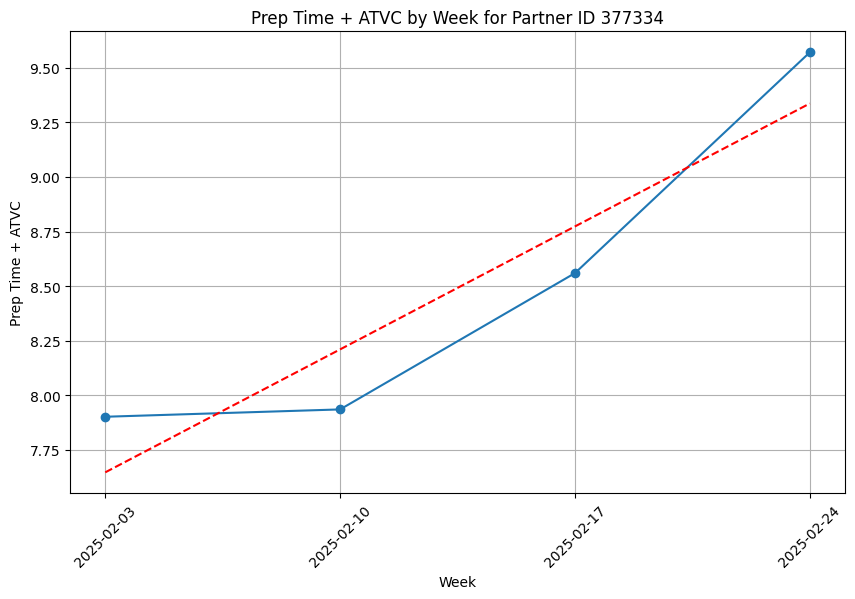

In [149]:

partners_tendencia['logistic_orders_created_date_local_week'] = pd.to_datetime(partners_tendencia['logistic_orders_created_date_local_week'])


# Filtrar los datos para el partner con id 377334
partner_data = partners_tendencia[partners_tendencia["dim_partner_partner_id"] == 20074]

# Graficar prep_time_mas_atvc por semana
plt.figure(figsize=(10, 6))
plt.plot(partner_data['logistic_orders_created_date_local_week'], partner_data['prep_time_mas_atvc'], marker='o')
plt.xlabel('Week')
plt.ylabel('Prep Time + ATVC')
plt.title('Prep Time + ATVC by Week for Partner ID 377334')
plt.xticks(rotation=45)
plt.grid(True)

# Convertir las fechas a valores numéricos
ordinal_dates = partner_data['logistic_orders_created_date_local_week'].map(pd.Timestamp.toordinal)

# Agregar línea de tendencia
z = np.polyfit(ordinal_dates, partner_data['prep_time_mas_atvc'], 1)
p = np.poly1d(z)
plt.plot(partner_data['logistic_orders_created_date_local_week'], p(ordinal_dates), "r--")

# Mostrar solo valores definidos en local_week en el eje x
plt.xticks(partner_data['logistic_orders_created_date_local_week'])
#revisar las semanas para considerar o no fin de mes
plt.show()

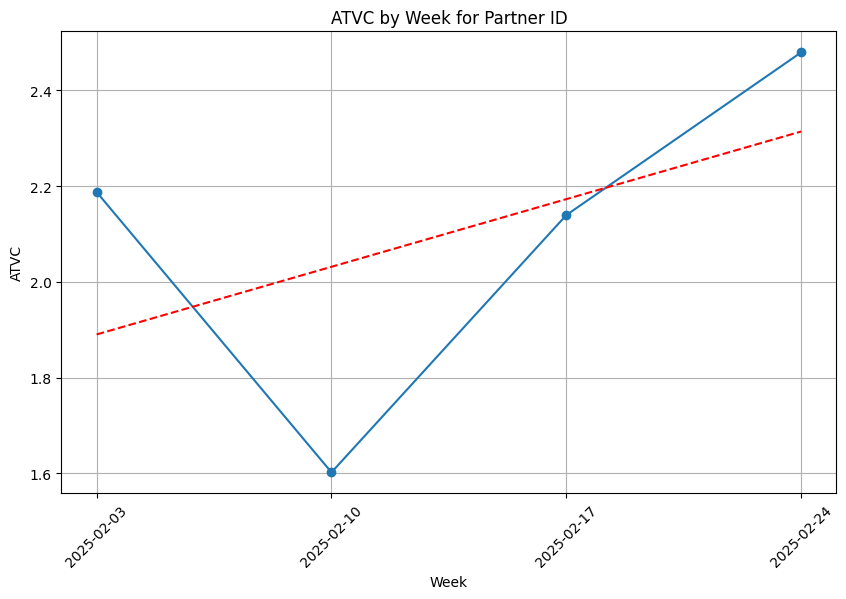

In [150]:

partners_tendencia['logistic_orders_created_date_local_week'] = pd.to_datetime(partners_tendencia['logistic_orders_created_date_local_week'])


# Filtrar los datos para el partner con id 377334
partner_data = partners_tendencia[partners_tendencia["dim_partner_partner_id"] == 20074.0]

# Graficar prep_time_mas_atvc por semana
plt.figure(figsize=(10, 6))
plt.plot(partner_data['logistic_orders_created_date_local_week'], partner_data['avg_at_vendor_time_cleaned'], marker='o')
plt.xlabel('Week')
plt.ylabel('ATVC')
plt.title('ATVC by Week for Partner ID')
plt.xticks(rotation=45)
plt.grid(True)

# Convertir las fechas a valores numéricos
ordinal_dates = partner_data['logistic_orders_created_date_local_week'].map(pd.Timestamp.toordinal)

# Agregar línea de tendencia
z = np.polyfit(ordinal_dates, partner_data['avg_at_vendor_time_cleaned'], 1)
p = np.poly1d(z)
plt.plot(partner_data['logistic_orders_created_date_local_week'], p(ordinal_dates), "r--")

# Mostrar solo valores definidos en local_week en el eje x
plt.xticks(partner_data['logistic_orders_created_date_local_week'])

plt.show()

In [151]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior) & (df1["logistic_orders_created_date_local_date"]<=fecha_superior) & (~df1["logistic_orders_created_date_local_date"].isin(["2025-02-09","2025-02-14","2025-02-26","2025-02-28"]))]
grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','franchise_name','mall','business_type_name','cuisine','Limite de Prep Time']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

prueba["diff_limite_%"]=prueba["avg_estimated_prep_time"]/prueba["Limite de Prep Time"]
total_orders=prueba["Orders"].sum()
prueba["%_orders"]=prueba["Orders"]/total_orders
partners_info=prueba.copy()
partners_info

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\3944514646.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior) & (df1["logistic_orders_created_date_local_date"]<=fecha_superior) & (~df1["logistic_orders_created_date_local_date"].isin(["2025-02-09","2025-02-14","2025-02-26","2025-02-28"]))]


,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders
0,77.0,subway parque arauco - 41767,subway,1,Restaurant,sándwiches,11.0,0.019231,0.102041,0.057692,9.884615,10.597407,0.712792,3.803401,52.0,13.688017,0.898601,2.399464e-05
1,828.0,pita house,no franchise,0,Restaurant,comida árabe,17.0,0.028391,0.045752,0.031646,11.611987,12.750519,1.138532,2.127303,317.0,13.739290,0.683058,1.462750e-04
2,849.0,pasta pazza,no franchise,0,Restaurant,pastas,24.0,0.000000,0.000000,0.000000,15.400000,17.066667,1.666667,2.197778,15.0,17.597778,0.641667,6.921530e-06
3,1031.0,niu sushi - tobalaba,niu,0,Restaurant,sushi,46.0,0.763578,0.055077,0.047541,46.629393,43.085636,-3.543757,1.528157,626.0,48.157550,1.013682,2.888585e-04
4,1112.0,los maestros,no franchise,0,Restaurant,pizzas,23.0,0.000000,0.000000,0.000000,18.000000,18.450000,0.450000,0.466667,1.0,18.466667,0.782609,4.614353e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12001,540913.0,pollo a la brasas los 7 pollos,no franchise,0,Restaurant,pollo asado,17.0,0.000000,0.000000,0.000000,13.000000,9.827778,-3.172222,0.337500,4.0,13.337500,0.764706,1.845741e-06
12002,540958.0,food truck ledaigna,no franchise,0,Restaurant,completos,17.0,0.000000,0.000000,0.000000,13.000000,9.533333,-3.466667,0.000000,1.0,13.000000,0.764706,4.614353e-07
12003,540968.0,sushi yakitori,no franchise,0,Restaurant,sushi,40.0,0.000000,0.222222,0.100000,13.000000,16.623810,3.623810,2.804167,13.0,15.804167,0.325000,5.998659e-06
12004,540971.0,papas punto,no franchise,0,Restaurant,comida casera,19.0,0.000000,0.333333,0.000000,13.000000,23.225000,10.225000,10.725000,4.0,23.725000,0.684211,1.845741e-06


In [152]:
partners_info['cambio'] = ((partners_info['diff_limite_%'] >= per_limite) & (partners_info['%vendorlate'] > vendor_late_min) & (partners_info['Orders'] > minimo_orders_partner))
partners_info[partners_info["cambio"]==True]    

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders,cambio
32,7696.0,china town reñaca,no franchise,0,Restaurant,comida china,15.0,0.227273,0.177966,0.048387,21.909091,23.952434,2.043344,4.483469,132.0,26.392560,1.460606,0.000061,True
46,17736.0,sabor al cuadrado,no franchise,0,Restaurant,pizzas,23.0,0.475000,0.322581,0.184211,27.187500,32.135069,4.947569,6.046094,80.0,33.233594,1.182065,0.000037,True
98,33638.0,el sanguchón peruano,el sanguchón peruano,0,Restaurant,comida peruana,20.0,0.363636,0.303030,0.175000,22.477273,27.051170,4.573897,5.895775,88.0,28.373047,1.123864,0.000041,True
126,38753.0,kfc vicuña mackenna,kfc,0,Restaurant,pollo frito,15.0,0.326139,0.243833,0.137480,20.301359,22.350560,2.049201,5.743637,1251.0,26.044996,1.353424,0.000577,True
134,39950.0,el puro perú,no franchise,0,Restaurant,comida peruana,21.0,0.458333,0.157895,0.146067,31.510417,31.905634,0.395217,3.364957,96.0,34.875374,1.500496,0.000044,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11556,533572.0,juan maestro - portal ñuñoa,juan maestro,0,Restaurant,sándwiches,20.0,0.938272,0.229508,0.237500,40.000000,40.957233,0.957233,5.462097,81.0,45.462097,2.000000,0.000037,True
11620,534322.0,"pedro, juan y diego- rancagua cuevas","pedro, juan y diego",0,Restaurant,hamburguesas,15.0,0.390558,0.470874,0.080357,18.987124,23.140827,4.153702,9.725987,233.0,28.713112,1.265808,0.000108,True
11761,535811.0,carl's jr cenco la florida,carl's jr.,0,Restaurant,hamburguesas,21.0,0.641221,0.521739,0.178571,23.671756,28.201412,4.529657,9.026333,131.0,32.698089,1.127226,0.000060,True
11802,536386.0,fuente de soda yakeline,no franchise,0,Restaurant,completos,17.0,0.195122,0.186441,0.169014,18.975610,22.287879,3.312269,5.047101,82.0,24.022711,1.116212,0.000038,True


In [153]:
#partners_info['cambio'] = ((partners_info['diff_limite_%'] >= 1.05) & (partners_info['Orders'] > minimo_orders_partner))

idspartnerssospechosos_limite=partners_info[(partners_info["cambio"]==1) & (~partners_info["dim_partner_partner_id"].isin(idspartnerssospechosos_slopes))]["dim_partner_partner_id"].unique()
idspartnerssospechosos = np.concatenate((idspartnerssospechosos_slopes, idspartnerssospechosos_limite))
idspartnerssospechosos

array([ 30109.,  38753.,  41202.,  47511.,  49978.,  49995.,  52045.,
        52046.,  52577.,  52806.,  57103.,  58022.,  58457.,  58689.,
        58871.,  58872.,  59080.,  59379.,  61453.,  62153.,  63621.,
        63667.,  63801.,  64323.,  64373.,  65207.,  65215.,  65644.,
        65691.,  65827.,  66053.,  66391.,  66486.,  66487.,  66488.,
        66490.,  66494.,  66557.,  66569.,  66945.,  67018.,  67409.,
        67410.,  67557.,  67564.,  67565.,  68202.,  68526.,  68594.,
        68595.,  68597.,  68598.,  68648.,  87509.,  87778.,  87784.,
        88287.,  88438.,  89120.,  90362.,  90564.,  99073.,  99899.,
        99938., 100824., 100940., 101277., 101279., 101316., 101326.,
       101351., 101454., 101545., 101839., 102178., 102217., 104501.,
       104934., 105942., 105973., 106853., 107241., 107687., 107754.,
       108168., 109384., 110263., 110506., 112061., 112509., 112822.,
       113256., 115154., 115473., 115508., 116112., 116769., 117047.,
       118285., 1195

In [154]:
partners_info[partners_info["dim_partner_partner_id"].isin(idspartnerssospechosos) ]["%_orders"].sum()

np.float64(0.2000885032930331)

In [155]:
partners_info[partners_info["dim_partner_partner_id"].isin(idspartnerssospechosos) ]

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders,cambio
32,7696.0,china town reñaca,no franchise,0,Restaurant,comida china,15.0,0.227273,0.177966,0.048387,21.909091,23.952434,2.043344,4.483469,132.0,26.392560,1.460606,0.000061,True
46,17736.0,sabor al cuadrado,no franchise,0,Restaurant,pizzas,23.0,0.475000,0.322581,0.184211,27.187500,32.135069,4.947569,6.046094,80.0,33.233594,1.182065,0.000037,True
72,30109.0,seiko sushi 1 poniente,seiko sushi,0,Restaurant,sushi,22.0,0.386179,0.198980,0.176471,21.577236,24.007039,2.429804,4.695191,246.0,26.272426,0.980783,0.000114,False
98,33638.0,el sanguchón peruano,el sanguchón peruano,0,Restaurant,comida peruana,20.0,0.363636,0.303030,0.175000,22.477273,27.051170,4.573897,5.895775,88.0,28.373047,1.123864,0.000041,True
126,38753.0,kfc vicuña mackenna,kfc,0,Restaurant,pollo frito,15.0,0.326139,0.243833,0.137480,20.301359,22.350560,2.049201,5.743637,1251.0,26.044996,1.353424,0.000577,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11757,535773.0,papa john's rahue,papa john's,0,Restaurant,pizzas,24.0,0.146944,0.170149,0.103079,16.084525,18.733073,2.648548,4.516131,769.0,20.600657,0.670189,0.000355,False
11761,535811.0,carl's jr cenco la florida,carl's jr.,0,Restaurant,hamburguesas,21.0,0.641221,0.521739,0.178571,23.671756,28.201412,4.529657,9.026333,131.0,32.698089,1.127226,0.000060,True
11764,535837.0,carl's jr mall plaza la serena,carl's jr.,0,Restaurant,hamburguesas,21.0,0.255882,0.185065,0.075075,14.370588,15.682937,1.312348,5.242279,340.0,19.612867,0.684314,0.000157,False
11802,536386.0,fuente de soda yakeline,no franchise,0,Restaurant,completos,17.0,0.195122,0.186441,0.169014,18.975610,22.287879,3.312269,5.047101,82.0,24.022711,1.116212,0.000038,True


In [156]:
949  /12572 

0.07548520521794463

PARTE 2

In [157]:
#parametros parte2
solucion_eje_x=1

limite_rider_arrival=10
limite_collection_time=25

pendiente_tendencia_positiva_alta=0.3
pendiente_tendencia_positiva_baja=-0.05
pendiente_tendencia_negativa_baja=-0.2

collection_time_alta=8
collection_time_media=4

por_alto=25

In [158]:

if flag ==0:
    
    sql1 = f"""


SELECT
    logistic_orders.country.country_name  AS logistic_orders_country__country_name,
        (FORMAT_DATE('%F', DATE_TRUNC(logistic_orders.created_date_local , WEEK(MONDAY)))) AS logistic_orders_created_date_local_week,
(logistic_orders.created_date_local ) AS logistic_orders_created_date_local_date,
        
    dim_partner.partner_name  AS dim_partner_partner_name,
    dim_partner.partner_id  AS dim_partner_partner_id,
logistic_orders.order_id,
logistic_orders.order_status,
    
    (FORMAT_DATE('%A', logistic_orders.created_date_local )) AS logistic_orders_created_date_local_day_of_week,
    (EXTRACT(HOUR FROM logistic_orders.created_at_local )) AS logistic_orders_created_at_local_hour_of_day,
    (EXTRACT(MONTH FROM logistic_orders.created_at_local )) AS logistic_orders_created_at_local_month,
    dim_partner.main_cousine_category_name as cuisine,
    dim_partner.franchise.franchise_name as franchise_name,
    dim_partner.business_type.business_type_name,
    logistic_orders.city.city_name as city,
     fact_logistic_orders__zone.zone_name  AS zone,



logistic_orders.is_vendor_late_10 as is_vendor_late_10,
logistic_orders.is_vendor_late_nn as is_vendor_late_nn,

 logistic_orders.is_rider_late_10 as is_rider_late_10,

logistic_orders.is_rider_late_nn as is_rider_late_nn,




logistic_orders.estimated_prep_time/60 as estimated_prep_time,


CASE WHEN ( logistic_orders.timings.actual_delivery_time*1.000/60  ) > 45 THEN 1 ELSE 0 END
  AS slow_delivery,

CASE WHEN ( fact_orders.promisedDeliveryTime.maxMinutes   + 10) < ( logistic_orders.timings.actual_delivery_time*1.000/60  )  THEN 1  ELSE 0 END AS lcf,


 
logistic_orders.timings.at_vendor_time_cleaned/60 at_vendor_time_cleaned,
logistic_orders.timings.at_vendor_time/60 at_vendor_time,
logistic_orders.timings.assumed_actual_preparation_time/60 as assumed_prep_time,
logistic_orders.timings.promised_delivery_time/60 as promised_delivery_time,

logistic_orders.timings.actual_delivery_time/60 as actual_delivery_time,
 

logistic_orders.timings.vendor_late/60 as vendor_late_min,
logistic_orders.timings.rider_late/60 as rider_late_min,
logistic_orders.timings.hold_back_time/60 as hold_back_time_min,
logistic_orders.timings.estimated_walk_in_duration/60 as estimated_walk_in_min,
logistic_orders.timings.estimated_walk_out_duration/60 as estimated_walk_out_min,

logistic_orders.timings.to_customer_time/60 as to_customer_time_min,
  

FROM `peya-bi-tools-pro.il_logistics.fact_logistic_orders` AS logistic_orders
LEFT JOIN `peya-bi-tools-pro.il_core.fact_orders`  AS fact_orders ON fact_orders.order_id= logistic_orders.peya_order_id and fact_orders.registered_date = logistic_orders.created_date_local

LEFT JOIN `peya-bi-tools-pro.il_core.dim_partner` AS dim_partner ON dim_partner.partner_id=fact_orders.restaurant.id
LEFT JOIN UNNEST (logistic_orders.deliveries) as fact_logistic_orders__deliveries
LEFT JOIN UNNEST([logistic_orders.zone]) as fact_logistic_orders__zone


WHERE  ( ( logistic_orders.created_date_local  ) between  DATE('{fecha_inferior}') AND DATE('{fecha_superior}'))

AND UPPER( logistic_orders.country.country_name  ) = UPPER('{country}')
AND (NOT (logistic_orders.is_preorder ) OR (logistic_orders.is_preorder ) IS NULL)


 AND ((fact_orders.restaurant.id ) > 0 OR (fact_orders.restaurant.id ) IS NULL) 
 AND (logistic_orders.peya_order_id ) IS NOT NULL



ORDER BY 15 DESC

    """
    data2=client.query(sql1).to_dataframe()
    data2.to_csv("data2.csv")
else:
    
    data2=pd.read_csv("data2.csv")

In [159]:
df2=data2
df2['logistic_orders_created_date_local_date'] = pd.to_datetime(df2['logistic_orders_created_date_local_date'])

df2['franchise_name'] = df2['franchise_name'].str.lower()
df2['cuisine'].fillna("no-cuisine", inplace=True)
df2['city'].fillna("no city", inplace=True)
df2['zone'].fillna("no zone", inplace=True)
df2['franchise_name'].fillna("no franchise", inplace=True)
df2['business_type_name'].fillna("no business", inplace=True)
df2["month"] = df2["logistic_orders_created_date_local_date"].dt.month
df2['logistic_orders_created_date_local_week'] = pd.to_datetime(df2['logistic_orders_created_date_local_week'])
df2['ept_atvc'] = df2['estimated_prep_time'] + df2['at_vendor_time_cleaned']


C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\3035933295.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['cuisine'].fillna("no-cuisine", inplace=True)
C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_14196\3035933295.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [160]:
df2

,Unnamed: 0,logistic_orders_country__country_name,logistic_orders_created_date_local_week,logistic_orders_created_date_local_date,dim_partner_partner_name,dim_partner_partner_id,order_id,order_status,logistic_orders_created_date_local_day_of_week,logistic_orders_created_at_local_hour_of_day,...,promised_delivery_time,actual_delivery_time,vendor_late_min,rider_late_min,hold_back_time_min,estimated_walk_in_min,estimated_walk_out_min,to_customer_time_min,month,ept_atvc
0,0,Chile,2025-01-27,2025-01-29,PedidosYa Market - Manquehue,289949.0,133703810,completed,Wednesday,21,...,29.983333,31.100000,7.750000,1.883333,0.000000,1.667,2.233,16.333333,1,12.850000
1,1,Chile,2025-02-17,2025-02-20,Happy Milkshake Ñuñoa,310628.0,135621337,completed,Thursday,16,...,25.983333,24.566667,2.500000,-0.050000,0.450000,2.000,2.450,14.583333,2,9.516667
2,2,Chile,2025-02-03,2025-02-04,Milá - Costanera Center.,481575.0,134210946,completed,Tuesday,13,...,64.983333,63.166667,17.100000,2.500000,0.983333,2.067,2.350,27.066667,2,32.583333
3,3,Chile,2025-02-03,2025-02-09,Local Burger - Las Condes,205935.0,134655844,completed,Sunday,12,...,31.966667,19.850000,0.000000,-6.883333,0.916667,1.700,2.517,9.783333,2,15.000000
4,4,Chile,2025-02-17,2025-02-21,Botilleria Los Molinos,227884.0,135763816,completed,Friday,22,...,15.983333,13.316667,0.000000,-4.000000,0.000000,2.333,2.500,8.366667,2,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093584,3093584,Chile,2025-02-24,2025-02-26,Churrascon 24/7,259095.0,136105548,completed,Wednesday,15,...,27.983333,32.000000,0.466667,9.916667,0.066667,0.967,2.450,9.516667,2,12.466667
3093585,3093585,Chile,2025-02-24,2025-02-28,Churrascon 24/7,259095.0,136321539,completed,Friday,19,...,34.983333,31.050000,1.266667,2.416667,0.466667,0.967,2.450,15.883333,2,12.266667
3093586,3093586,Chile,2025-02-17,2025-02-20,Churrascon 24/7,259095.0,135627232,completed,Thursday,17,...,25.983333,19.066667,0.000000,-5.100000,0.833333,0.600,2.300,12.366667,2,9.000000
3093587,3093587,Chile,2025-02-24,2025-02-26,NaN,NaN,136117448,cancelled,Wednesday,17,...,30.000000,0.000000,NaN,NaN,0.750000,1.500,1.500,0.000000,2,18.000000


In [161]:
df2["collection_time"]=df2["at_vendor_time"] - df2["estimated_walk_in_min"]
df2["rider_arrival"]=df2["rider_late_min"]
df2 = df2.dropna(subset=['rider_arrival', 'collection_time'])


In [162]:
# Inicializar una lista para guardar los resultados combinados
results_combined = []

# Iterar sobre cada id en el array idspartnerssospechosos
for partner_id_estudio in idspartnerssospechosos:
    dfchart = df2[
        (df2["dim_partner_partner_id"] == partner_id_estudio) &
        (df2["rider_arrival"] <= limite_rider_arrival) &
        (df2["rider_arrival"] >= -limite_rider_arrival) &  
        (df2["collection_time"] >= -limite_collection_time) & 
        (df2["collection_time"] <= limite_collection_time)
    ]

    if len(dfchart) == 0:
        continue

    partner_name = dfchart["dim_partner_partner_name"].iloc[0]

    # Definir la función lineal por tramos
    def piecewise_linear(x, x0, y0, k1, k2):
        return np.where(x < x0, k1 * (x - x0) + y0, k2 * (x - x0) + y0)

    bounds = ([-solucion_eje_x, -np.inf, -np.inf, -np.inf], [solucion_eje_x, np.inf, np.inf, np.inf])
    
    # Ajustar el modelo a los datos "despues"
    p0 = [0, 0, -1, 0]
    popt, _ = curve_fit(piecewise_linear, dfchart['rider_arrival'], dfchart['collection_time'], p0, bounds=bounds)

    x_offset = popt[0]
    y_offset = popt[1]
    
    # Calcular el porcentaje de puntos después del cambio de pendiente
    total_points = len(dfchart)
    points_after = len(dfchart[dfchart['rider_arrival'] > x_offset])
    points_after_abajo = len(dfchart[(dfchart['rider_arrival'] > x_offset) & (dfchart['collection_time'] <= y_offset)])
    percentage_after = (points_after / total_points) * 100

    # Guardar los parámetros ajustados
    results_combined.append({
        'partner_id': partner_id_estudio,
        'partner_name': partner_name,
        'x0': popt[0],
        'y0': popt[1],
        'k1': popt[2],
        'k2': popt[3],
        '%_despues': percentage_after,
    })

results_df = pd.DataFrame(results_combined)

In [163]:
results_df

,partner_id,partner_name,x0,y0,k1,k2,%_despues
0,30109.0,Seiko Sushi 1 Poniente,-1.000000,1.258868,-0.752761,0.184753,60.360360
1,38753.0,KFC Vicuña Mackenna,-1.000000,3.626417,-0.244614,0.120106,44.954128
2,41202.0,China Wok Recoleta,0.733335,4.700289,0.045601,-0.193043,24.154589
3,47511.0,Juan Maestro Líder Puente Alto,-1.000000,4.565991,-0.194143,-0.333319,26.415094
4,49978.0,Dunkin' Florida Center,1.000000,0.383207,-0.345939,-0.063484,14.617940
...,...,...,...,...,...,...,...
750,533572.0,Juan Maestro - Portal Ñuñoa,1.000000,6.112986,0.182876,-0.370935,47.540984
751,534322.0,"Pedro, Juan Y Diego- Rancagua Cuevas",1.000000,9.756323,0.089640,-0.267795,18.636364
752,535811.0,Carl's Jr Cenco La Florida,-0.854604,7.267222,-0.328036,0.278426,53.600000
753,536386.0,Fuente De Soda Yakeline,1.000000,3.800436,-0.594502,0.429986,22.857143


In [164]:
pendiente_tendencia_positiva_alta

0.3

In [165]:


results_df['tendencia_categoria'] = results_df.apply(
    lambda row: (
        'tendencia_positiva_alta' if ( row['k2'] >= pendiente_tendencia_positiva_alta )

        else 
        'tendencia_positiva_baja' if ( row['k2'] >= pendiente_tendencia_positiva_baja )

        else
        
        'tendencia_negativa_baja' if ( row['k2'] >= pendiente_tendencia_negativa_baja )

        else
        'tendencia_negativa_alta'
        
    ),
    axis=1
)

results_df['collection_time_categoria'] = results_df.apply(
    lambda row: (
        'alto' if ( row['y0'] >= collection_time_alta )

        else 
        'medio' if ( row['y0'] >= collection_time_media )

        else
        'bajo'
        

    ),
    axis=1
)


results_df['%_categoria'] = results_df.apply(
    lambda row: (
        '%_alto' if ( row['%_despues'] >= por_alto)

        else
        '%_baja'
        
    ),
    axis=1
)



In [166]:
results_df[results_df["tendencia_categoria"]=="tendencia_positiva_alta"]

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria
6,52045.0,China Wok Costanera Center,1.000000,2.380067,-0.126164,0.690674,15.591398,tendencia_positiva_alta,bajo,%_baja
12,58457.0,McDonald's Plaza Italia,0.566681,2.277508,-0.540202,0.337681,17.751479,tendencia_positiva_alta,bajo,%_baja
15,58872.0,China Wok Mall Plaza Bio Bio,0.983341,1.936459,-0.230310,0.763602,10.000000,tendencia_positiva_alta,bajo,%_baja
22,63801.0,Burger King® - La Dehesa,1.000000,4.007995,-0.450682,0.420501,21.034483,tendencia_positiva_alta,medio,%_baja
46,68202.0,Tarragona Mall Barrio Independencia,1.000000,0.674184,-0.236689,0.357878,19.653179,tendencia_positiva_alta,bajo,%_baja
...,...,...,...,...,...,...,...,...,...,...
711,508953.0,Rustico Restobar,-0.016686,1.478589,-0.825185,0.300638,23.239437,tendencia_positiva_alta,bajo,%_baja
736,524945.0,Buffalo Waffles - Mall Plaza Antofagasta,1.000000,2.470405,-0.079579,0.322571,30.107527,tendencia_positiva_alta,bajo,%_alto
739,527429.0,El Quinto Elemento Sandwichería,-0.866670,4.523455,-0.790640,0.309421,30.882353,tendencia_positiva_alta,medio,%_alto
744,528506.0,Texas Burger - Iquique,1.000000,5.426418,-1.394768,0.314846,41.250000,tendencia_positiva_alta,medio,%_alto


In [167]:
#cambios

In [168]:
# Crear la columna 'cambio_final' con las condiciones especificadas
results_df['cambio_final'] = results_df.apply(
    lambda row: (
        True if row['collection_time_categoria'] == 'alto' or 

        (row['collection_time_categoria'] == 'medio' and row['tendencia_categoria'] in ['tendencia_positiva_baja', 'tendencia_positiva_alta'])
        
        or (row['collection_time_categoria'] == 'bajo' and row['tendencia_categoria'] in ['tendencia_positiva_alta'] and row['%_categoria'] in ['%_alto'] )
        
        else False
    ),
    axis=1
)

# Mostrar el dataframe con la nueva columna
results_df

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final
0,30109.0,Seiko Sushi 1 Poniente,-1.000000,1.258868,-0.752761,0.184753,60.360360,tendencia_positiva_baja,bajo,%_alto,False
1,38753.0,KFC Vicuña Mackenna,-1.000000,3.626417,-0.244614,0.120106,44.954128,tendencia_positiva_baja,bajo,%_alto,False
2,41202.0,China Wok Recoleta,0.733335,4.700289,0.045601,-0.193043,24.154589,tendencia_negativa_baja,medio,%_baja,False
3,47511.0,Juan Maestro Líder Puente Alto,-1.000000,4.565991,-0.194143,-0.333319,26.415094,tendencia_negativa_alta,medio,%_alto,False
4,49978.0,Dunkin' Florida Center,1.000000,0.383207,-0.345939,-0.063484,14.617940,tendencia_negativa_baja,bajo,%_baja,False
...,...,...,...,...,...,...,...,...,...,...,...
750,533572.0,Juan Maestro - Portal Ñuñoa,1.000000,6.112986,0.182876,-0.370935,47.540984,tendencia_negativa_alta,medio,%_alto,False
751,534322.0,"Pedro, Juan Y Diego- Rancagua Cuevas",1.000000,9.756323,0.089640,-0.267795,18.636364,tendencia_negativa_alta,alto,%_baja,True
752,535811.0,Carl's Jr Cenco La Florida,-0.854604,7.267222,-0.328036,0.278426,53.600000,tendencia_positiva_baja,medio,%_alto,True
753,536386.0,Fuente De Soda Yakeline,1.000000,3.800436,-0.594502,0.429986,22.857143,tendencia_positiva_alta,bajo,%_baja,False


In [169]:
results_df['cambio_final_cateogry'] = results_df.apply(
    lambda row: (
        "categoria_1" if row['collection_time_categoria'] == 'alto' else
        "categoria_2" if  (row['collection_time_categoria'] == 'medio' and row['tendencia_categoria'] in ['tendencia_positiva_baja', 'tendencia_positiva_alta']) else
        "categoria_3" if (row['collection_time_categoria'] == 'bajo' and row['tendencia_categoria'] in ['tendencia_positiva_alta'] and row['%_categoria'] in ['%_alto'] )
        
        else False
    ),
    axis=1
)

# Mostrar el dataframe con la nueva columna
results_df

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final,cambio_final_cateogry
0,30109.0,Seiko Sushi 1 Poniente,-1.000000,1.258868,-0.752761,0.184753,60.360360,tendencia_positiva_baja,bajo,%_alto,False,False
1,38753.0,KFC Vicuña Mackenna,-1.000000,3.626417,-0.244614,0.120106,44.954128,tendencia_positiva_baja,bajo,%_alto,False,False
2,41202.0,China Wok Recoleta,0.733335,4.700289,0.045601,-0.193043,24.154589,tendencia_negativa_baja,medio,%_baja,False,False
3,47511.0,Juan Maestro Líder Puente Alto,-1.000000,4.565991,-0.194143,-0.333319,26.415094,tendencia_negativa_alta,medio,%_alto,False,False
4,49978.0,Dunkin' Florida Center,1.000000,0.383207,-0.345939,-0.063484,14.617940,tendencia_negativa_baja,bajo,%_baja,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
750,533572.0,Juan Maestro - Portal Ñuñoa,1.000000,6.112986,0.182876,-0.370935,47.540984,tendencia_negativa_alta,medio,%_alto,False,False
751,534322.0,"Pedro, Juan Y Diego- Rancagua Cuevas",1.000000,9.756323,0.089640,-0.267795,18.636364,tendencia_negativa_alta,alto,%_baja,True,categoria_1
752,535811.0,Carl's Jr Cenco La Florida,-0.854604,7.267222,-0.328036,0.278426,53.600000,tendencia_positiva_baja,medio,%_alto,True,categoria_2
753,536386.0,Fuente De Soda Yakeline,1.000000,3.800436,-0.594502,0.429986,22.857143,tendencia_positiva_alta,bajo,%_baja,False,False


In [170]:
badners_enero=pd.read_csv("Segumiento Badners - Sheet12.csv")
badners_enero

,Nombre Partner,Partner_id
0,kfc centro calama,531058
1,tarragona la fábrica patio outlet,101351
2,under pizza - apoquindo,480094
3,under pizza - concepción,488934
4,wendy´s pionero,521115
...,...,...
94,promo sushi la serena,330824
95,doggis - espacio urbano punta arenas,504483
96,under pizza - estación central,237082
97,under pizza - san felipe,477996


In [171]:
results_df[(results_df["cambio_final"]==True) & (~results_df["partner_id"].isin(badners_enero["Partner_id"].values))]

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final,cambio_final_cateogry
22,63801.0,Burger King® - La Dehesa,1.000000,4.007995,-0.450682,0.420501,21.034483,tendencia_positiva_alta,medio,%_baja,True,categoria_2
37,66557.0,Burger King® - La Florida,1.000000,7.325161,-0.152148,0.120382,41.422594,tendencia_positiva_baja,medio,%_alto,True,categoria_2
40,67018.0,McDonald's Vespucio Exterior,1.000000,5.447216,-0.233331,-0.025188,37.195994,tendencia_positiva_baja,medio,%_alto,True,categoria_2
56,88287.0,Melt Pizzas - La Florida,-1.000000,4.211590,-0.217440,0.118881,38.425197,tendencia_positiva_baja,medio,%_alto,True,categoria_2
73,101839.0,Sol Y Sabor Sanguchería,0.883341,4.113470,-0.132775,0.275803,10.152284,tendencia_positiva_baja,medio,%_baja,True,categoria_2
...,...,...,...,...,...,...,...,...,...,...,...,...
739,527429.0,El Quinto Elemento Sandwichería,-0.866670,4.523455,-0.790640,0.309421,30.882353,tendencia_positiva_alta,medio,%_alto,True,categoria_2
744,528506.0,Texas Burger - Iquique,1.000000,5.426418,-1.394768,0.314846,41.250000,tendencia_positiva_alta,medio,%_alto,True,categoria_2
751,534322.0,"Pedro, Juan Y Diego- Rancagua Cuevas",1.000000,9.756323,0.089640,-0.267795,18.636364,tendencia_negativa_alta,alto,%_baja,True,categoria_1
752,535811.0,Carl's Jr Cenco La Florida,-0.854604,7.267222,-0.328036,0.278426,53.600000,tendencia_positiva_baja,medio,%_alto,True,categoria_2


In [172]:
results_df[(results_df["cambio_final"]==True) & (~results_df["partner_id"].isin(badners_enero["Partner_id"].values))].nunique()

partner_id                   99
partner_name                 99
x0                           87
y0                           99
k1                           99
k2                           99
%_despues                    98
tendencia_categoria           4
collection_time_categoria     3
%_categoria                   2
cambio_final                  1
cambio_final_cateogry         3
dtype: int64

In [173]:
results_df[results_df["cambio_final"]==True]

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final,cambio_final_cateogry
22,63801.0,Burger King® - La Dehesa,1.000000,4.007995,-0.450682,0.420501,21.034483,tendencia_positiva_alta,medio,%_baja,True,categoria_2
37,66557.0,Burger King® - La Florida,1.000000,7.325161,-0.152148,0.120382,41.422594,tendencia_positiva_baja,medio,%_alto,True,categoria_2
40,67018.0,McDonald's Vespucio Exterior,1.000000,5.447216,-0.233331,-0.025188,37.195994,tendencia_positiva_baja,medio,%_alto,True,categoria_2
56,88287.0,Melt Pizzas - La Florida,-1.000000,4.211590,-0.217440,0.118881,38.425197,tendencia_positiva_baja,medio,%_alto,True,categoria_2
73,101839.0,Sol Y Sabor Sanguchería,0.883341,4.113470,-0.132775,0.275803,10.152284,tendencia_positiva_baja,medio,%_baja,True,categoria_2
...,...,...,...,...,...,...,...,...,...,...,...,...
743,528485.0,Sabor De Pakistan,-1.000000,11.689676,1.416806,-1.017929,50.000000,tendencia_negativa_alta,alto,%_alto,True,categoria_1
744,528506.0,Texas Burger - Iquique,1.000000,5.426418,-1.394768,0.314846,41.250000,tendencia_positiva_alta,medio,%_alto,True,categoria_2
751,534322.0,"Pedro, Juan Y Diego- Rancagua Cuevas",1.000000,9.756323,0.089640,-0.267795,18.636364,tendencia_negativa_alta,alto,%_baja,True,categoria_1
752,535811.0,Carl's Jr Cenco La Florida,-0.854604,7.267222,-0.328036,0.278426,53.600000,tendencia_positiva_baja,medio,%_alto,True,categoria_2


In [174]:
final_cambiosid=results_df[(results_df["cambio_final"]==True) & (~results_df["partner_id"].isin(badners_enero["Partner_id"].values))]["partner_id"].unique()
final_cambiosid

array([ 63801.,  66557.,  67018.,  88287., 101839., 115154., 134427.,
       134516., 139542., 161571., 186729., 205410., 220084., 225444.,
       226029., 231151., 262169., 287455., 291016., 316068., 319823.,
       327965., 348647., 355488., 368213., 368623., 378810., 387875.,
       393201., 404147., 417271., 422067., 424039., 425089., 433426.,
       449284., 454265., 473473., 478699., 497367., 499773., 503392.,
       503710., 517705., 519648., 520746., 522481., 523824., 526275.,
       527150., 527844., 532873.,   7696.,  48599.,  49975.,  53377.,
        57297.,  67830.,  87771.,  87802., 106538., 110477., 120974.,
       134623., 135646., 140874., 142164., 154820., 157803., 173008.,
       186978., 221086., 223682., 225185., 247568., 261452., 370663.,
       376201., 422029., 425070., 443905., 477848., 491155., 492111.,
       495966., 496684., 499839., 499868., 509615., 514436., 517031.,
       523630., 524945., 526342., 527429., 528506., 534322., 535811.,
       537338.])

In [176]:
partners_info[(partners_info["dim_partner_partner_id"].isin(final_cambiosid)) & (~partners_info["dim_partner_partner_id"].isin(badners_enero["Partner_id"].values)) ]["%_orders"].sum()

np.float64(0.02293887227978115)

In [175]:
partners_info[(partners_info["dim_partner_partner_id"].isin(final_cambiosid)) & (~partners_info["dim_partner_partner_id"].isin(badners_enero["Partner_id"].values)) ].sort_values(by="%_orders",ascending=False)

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders,cambio
8853,478699.0,mcdonald's calama,mcdonald's,0,Restaurant,hamburguesas,16.0,0.094353,0.199751,0.029760,13.109602,14.285747,1.176145,5.244156,4197.0,18.353758,0.819350,0.001937,False
4486,262169.0,mcdonald´s pajaritos ii,mcdonald's,0,Restaurant,hamburguesas,16.0,0.375725,0.228810,0.119481,21.568701,22.964713,1.396012,5.147147,2933.0,26.715848,1.348044,0.001353,True
10650,519648.0,mcdonald´s - macul las torres,mcdonald's,0,Restaurant,hamburguesas,16.0,0.330361,0.188312,0.140865,19.681230,19.730597,0.049366,4.653186,2243.0,24.334417,1.230077,0.001035,True
4837,291016.0,papa john´s - coronel,papa john's,0,Restaurant,pizzas,24.0,0.396325,0.186628,0.047619,29.472441,29.215840,-0.256601,4.602048,1905.0,34.074489,1.228018,0.000879,True
11131,527844.0,under pizza - curauma,under pizzas,0,Restaurant,pizzas,30.0,0.341235,0.182141,0.039205,28.343440,29.419526,1.076086,4.905610,1814.0,33.249050,0.944781,0.000837,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,106538.0,doggis mall arauco maipú,doggis,1,Restaurant,completos,20.0,0.742424,0.543860,0.095238,28.878788,33.925000,5.046212,12.148870,66.0,41.027658,1.443939,0.000030,True
408,57297.0,dominó - marina arauco,dominó,1,Restaurant,completos,10.0,0.428571,0.347826,0.269841,13.222222,15.728105,2.505882,6.639855,63.0,19.862077,1.322222,0.000029,True
4351,247568.0,mei xin comida china,no franchise,0,Restaurant,comida china,15.0,0.317460,0.369565,0.233333,16.777778,20.522973,3.745195,8.204861,63.0,24.982639,1.118519,0.000029,True
9434,492111.0,zaferani sabor de oriente- imperial,no franchise,0,Restaurant,comida árabe,17.0,0.682540,0.461538,0.118644,31.174603,36.016216,4.841613,9.559936,63.0,40.734539,1.833800,0.000029,True


In [124]:
176 /12500

0.01408

In [177]:
#cambio
fecha_inferior_cambio="2025-03-03"
disminucionept=0.5

In [179]:


dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior_cambio)  & (df1["dim_partner_partner_id"].isin(final_cambiosid)) ]
grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','franchise_name','mall','business_type_name','cuisine','Limite de Prep Time','city']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

prueba["diff_limite_%"]=prueba["avg_estimated_prep_time"]/prueba["Limite de Prep Time"]
total_orders=prueba["Orders"].sum()
prueba["%_orders"]=prueba["Orders"]/total_orders

partners_info_cambio=prueba.copy()
#partners_info_cambio=partners_info_cambio[partners_info_cambio["%vendorlate"]>=0.25]
partners_info_cambio

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,city,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders
0,7696.0,china town reñaca,no franchise,0,Restaurant,comida china,15.0,Vina del mar,0.117647,0.066667,0.000000,20.352941,20.069048,-0.283894,3.521875,17.0,23.874816,1.356863,0.003953
1,48599.0,shawarma el porvenir,local hero cl,0,Restaurant,comida árabe,20.0,Santiago,0.600000,0.111111,0.100000,28.200000,32.866667,4.666667,5.638889,10.0,33.838889,1.410000,0.002325
2,49975.0,dunkin' apumanque,dunkin donuts,1,Restaurant,cafetería,14.0,Santiago,0.100000,0.210526,0.050000,16.450000,18.815385,2.365385,5.627193,20.0,22.077193,1.175000,0.004650
3,53377.0,"pedro, juan y diego - plaza alameda","pedro, juan y diego",0,Restaurant,hamburguesas,15.0,Los angeles,0.000000,NaN,NaN,17.000000,NaN,NaN,0.000000,1.0,17.000000,1.133333,0.000233
4,53377.0,"pedro, juan y diego - plaza alameda","pedro, juan y diego",0,Restaurant,hamburguesas,15.0,Santiago,0.428571,0.666667,0.142857,16.142857,22.316667,6.173810,10.844444,7.0,26.987302,1.076190,0.001628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,528506.0,texas burger - iquique,no franchise,0,Restaurant,hamburguesas,19.0,Iquique,1.000000,0.000000,0.000000,32.000000,32.000000,0.000000,5.850000,1.0,37.850000,1.684211,0.000233
94,532873.0,wendy's eu gran avenida,wendy's,0,Restaurant,hamburguesas,19.0,Santiago,0.282051,0.235294,0.081081,23.282051,26.121111,2.839060,6.658824,39.0,29.940875,1.225371,0.009068
95,534322.0,"pedro, juan y diego- rancagua cuevas","pedro, juan y diego",0,Restaurant,hamburguesas,15.0,Rancagua,0.500000,0.317073,0.046512,21.934783,26.843651,4.908868,8.270635,46.0,30.205418,1.462319,0.010695
96,535811.0,carl's jr cenco la florida,carl's jr.,0,Restaurant,hamburguesas,21.0,Santiago,0.625000,0.333333,0.142857,27.250000,26.287500,-0.962500,4.483333,8.0,31.733333,1.297619,0.001860


In [180]:
partners_info_cambio=partners_info_cambio.merge(results_df[["partner_id","cambio_final_cateogry"]],how="left",left_on="dim_partner_partner_id",right_on="partner_id")
partners_info_cambio

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,city,%slowdelivery,%vendorlate,...,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders,partner_id,cambio_final_cateogry
0,7696.0,china town reñaca,no franchise,0,Restaurant,comida china,15.0,Vina del mar,0.117647,0.066667,...,20.352941,20.069048,-0.283894,3.521875,17.0,23.874816,1.356863,0.003953,7696.0,categoria_3
1,48599.0,shawarma el porvenir,local hero cl,0,Restaurant,comida árabe,20.0,Santiago,0.600000,0.111111,...,28.200000,32.866667,4.666667,5.638889,10.0,33.838889,1.410000,0.002325,48599.0,categoria_2
2,49975.0,dunkin' apumanque,dunkin donuts,1,Restaurant,cafetería,14.0,Santiago,0.100000,0.210526,...,16.450000,18.815385,2.365385,5.627193,20.0,22.077193,1.175000,0.004650,49975.0,categoria_2
3,53377.0,"pedro, juan y diego - plaza alameda","pedro, juan y diego",0,Restaurant,hamburguesas,15.0,Los angeles,0.000000,NaN,...,17.000000,NaN,NaN,0.000000,1.0,17.000000,1.133333,0.000233,53377.0,categoria_2
4,53377.0,"pedro, juan y diego - plaza alameda","pedro, juan y diego",0,Restaurant,hamburguesas,15.0,Santiago,0.428571,0.666667,...,16.142857,22.316667,6.173810,10.844444,7.0,26.987302,1.076190,0.001628,53377.0,categoria_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,528506.0,texas burger - iquique,no franchise,0,Restaurant,hamburguesas,19.0,Iquique,1.000000,0.000000,...,32.000000,32.000000,0.000000,5.850000,1.0,37.850000,1.684211,0.000233,528506.0,categoria_2
94,532873.0,wendy's eu gran avenida,wendy's,0,Restaurant,hamburguesas,19.0,Santiago,0.282051,0.235294,...,23.282051,26.121111,2.839060,6.658824,39.0,29.940875,1.225371,0.009068,532873.0,categoria_2
95,534322.0,"pedro, juan y diego- rancagua cuevas","pedro, juan y diego",0,Restaurant,hamburguesas,15.0,Rancagua,0.500000,0.317073,...,21.934783,26.843651,4.908868,8.270635,46.0,30.205418,1.462319,0.010695,534322.0,categoria_1
96,535811.0,carl's jr cenco la florida,carl's jr.,0,Restaurant,hamburguesas,21.0,Santiago,0.625000,0.333333,...,27.250000,26.287500,-0.962500,4.483333,8.0,31.733333,1.297619,0.001860,535811.0,categoria_2


In [181]:
partners_info_cambio["CODE"]=partners_info_cambio["dim_partner_partner_id"]
partners_info_cambio["DAY-RANGE"]="MONDAY-SUNDAY"
partners_info_cambio["HOUR-RANGE"]="0-23"
partners_info_cambio["PREPARATION-BUFFER"]=1
partners_info_cambio["PREPARATION-TIME"] = round(partners_info_cambio["avg_estimated_prep_time"] * disminucionept)
partners_info_cambio["PREPARATION-TIME"] = partners_info_cambio["PREPARATION-TIME"].apply(lambda x: max(x, 5))
partners_info_cambio["STRATEGY"]="OPS_PERMANENT"
partners_info_cambio.to_csv("cambios_final.csv")

In [51]:


dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior_cambio) ]
grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','franchise_name','mall','business_type_name','cuisine','Limite de Prep Time','city']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

prueba["diff_limite_%"]=prueba["avg_estimated_prep_time"]/prueba["Limite de Prep Time"]
total_orders=prueba["Orders"].sum()
prueba["%_orders"]=prueba["Orders"]/total_orders
prueba

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,city,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders
0,77.0,subway parque arauco - 41767,subway,1,Restaurant,sándwiches,12.0,Santiago,0.000000,0.285714,0.000000,9.000000,11.550000,2.550000,5.171429,7.0,14.171429,0.750000,0.000013
1,828.0,pita house,no franchise,0,Restaurant,comida árabe,17.0,Santiago,0.008850,0.018519,0.044248,11.929204,12.945500,1.016296,1.910802,113.0,13.840006,0.701718,0.000213
2,1031.0,niu sushi - tobalaba,niu,0,Restaurant,sushi,49.0,Santiago,0.984536,0.177143,0.074074,47.845361,48.115556,0.270195,4.321281,194.0,52.166641,0.976436,0.000366
3,1112.0,los maestros,no franchise,0,Restaurant,pizzas,24.0,Santiago,0.000000,0.200000,0.000000,12.500000,16.425000,3.925000,7.660000,6.0,20.160000,0.520833,0.000011
4,1869.0,tarragona independencia rancagua,tarragona,0,Restaurant,sándwiches,14.0,Rancagua,0.016393,0.069565,0.033613,12.196721,12.758333,0.561612,2.512147,122.0,14.708868,0.871194,0.000230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11032,534790.0,la fuente ñuñoa,no franchise,0,Restaurant,sándwiches,18.0,Santiago,0.111111,0.000000,0.111111,13.000000,14.054762,1.054762,1.760417,9.0,14.760417,0.722222,0.000017
11033,534834.0,migas - quilicura,no franchise,0,Restaurant,sushi,40.0,Santiago,1.000000,1.000000,0.000000,13.000000,NaN,NaN,17.700000,1.0,30.700000,0.325000,0.000002
11034,534954.0,espacio chicago - comida rapida,no franchise,0,Restaurant,empanadas,17.0,La serena,0.000000,0.000000,0.000000,13.000000,15.300000,2.300000,2.305556,3.0,15.305556,0.764706,0.000006
11035,534989.0,club del poke - santa amalia,no franchise,0,Restaurant,poke,23.0,Santiago,0.200000,1.000000,0.333333,13.000000,NaN,NaN,7.833333,5.0,20.833333,0.565217,0.000009


In [52]:
prueba[prueba["dim_partner_partner_id"].isin(final_cambiosid) ]["%_orders"].sum()


np.float64(0.02681835656296877)

In [58]:
partners_pasados=pd.read_csv("Partners que esperan al rider para preparar el pedido enero - iteracion noviembre.csv")
partners_pasados

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,city,%slowdelivery,%vendorlate,...,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders,resultado metolodgía,Se repite?,estado actual,PQP
0,511500,peco - comida peruana,no franchise,0,Restaurant,comida peruana,21,Santiago,0.666667,100.00%,...,8.377778,21.936667,6,35.936667,0.666667,0.0005308325223,exito,no,mal,Sin PQP
1,482574,almazen de cruda,no franchise,0,Restaurant,cafetería,14,Calama,0.250000,77.78%,...,3.531481,18.301389,40,27.301389,0.642857,0.003538883482,exito,no,mal,Sin PQP
2,259378,katana delivery chiguayante.,no franchise,0,Restaurant,sushi,40,Concepcion,0.400000,66.67%,...,5.658333,10.416667,5,27.416667,0.425000,0.0004423604353,exito,no,mal,Sin PQP
3,283634,papa john's - peñaflor,papa john's,0,Restaurant,pizzas,25,Penaflor,0.321739,55.67%,...,3.726667,10.967162,115,26.967162,0.640000,0.01017429001,exito,no,mal,Javier Peñaloza
4,425093,pronto antofagasta,pronto copec,0,Restaurant,hamburguesas,19,Antofagasta,0.178182,50.79%,...,5.848377,10.848404,275,16.281131,0.285933,0.02432982394,exito,no,mal,Macka Ramirez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,409077,donde fud,no franchise,0,Restaurant,completos,18,San felipe los andes,0.000000,3.33%,...,-0.155934,2.629032,31,24.080645,1.191756,0.002742634699,exito,no,bien,Sin PQP
73,153599,restaurant cosmo pollo,no franchise,0,Restaurant,pollo asado,16,Calama,0.005051,2.06%,...,-0.984249,1.471564,198,13.471564,0.750000,0.01751747324,exito,no,bien,Sin PQP
74,62219,sushi lovers 27,sushi lovers,0,Restaurant,sushi,24,Santiago,0.153846,0.00%,...,-0.581784,1.003030,39,23.413287,0.933761,0.003450411395,exito,no,bien,Sin PQP
75,62714,subway colón,subway,0,Restaurant,sándwiches,12,Santiago,0.000000,0.00%,...,4.735000,4.173077,13,10.173077,0.500000,0.001150137132,exito,no,bien,Franco Lagos KA


In [59]:
prueba[prueba["dim_partner_partner_id"].isin(partners_pasados["dim_partner_partner_id"].values) ]["%_orders"].sum()

np.float64(0.014768846910546432)

In [57]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior_cambio)  & (df1["dim_partner_partner_id"].isin(partners_pasados["dim_partner_partner_id"].values)) ]
grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','franchise_name','mall','business_type_name','cuisine','Limite de Prep Time','city']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

prueba["diff_limite_%"]=prueba["avg_estimated_prep_time"]/prueba["Limite de Prep Time"]
total_orders=prueba["Orders"].sum()
prueba["%_orders"]=prueba["Orders"]/total_orders
prueba

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,city,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,diff_limite_%,%_orders
0,42452.0,kfc general velásquez,kfc,0,Restaurant,pollo frito,18.0,Santiago,0.265957,0.231405,0.097015,17.425532,18.107179,0.681648,5.259649,282.0,22.685181,0.968085,0.024949
1,47552.0,juan maestro mall plaza oeste,juan maestro,1,Restaurant,sándwiches,21.0,Santiago,0.090909,0.090909,0.000000,14.000000,13.315972,-0.684028,3.007071,33.0,17.007071,0.666667,0.002920
2,48974.0,el puro perú - providencia,no franchise,0,Restaurant,comida peruana,21.0,Santiago,0.476744,0.375000,0.111111,23.593023,26.789744,3.196720,7.577111,86.0,31.170134,1.123477,0.007609
3,49369.0,tommy beans espacio m,tommy beans,0,Restaurant,comida mexicana,18.0,Santiago,0.200000,0.071429,0.066667,13.400000,15.926667,2.526667,4.300595,30.0,17.700595,0.744444,0.002654
4,53138.0,dominó - los dominicos,dominó,1,Restaurant,completos,11.0,Santiago,0.138889,0.285714,0.151515,7.000000,9.735714,2.735714,6.510556,36.0,13.510556,0.636364,0.003185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,502965.0,barrio chicken - agustinas,barrio chicken,0,Restaurant,sándwiches,29.0,Santiago,0.428571,0.384615,0.071429,22.000000,24.764286,2.764286,9.102564,14.0,31.102564,0.758621,0.001239
112,503710.0,under pizza - la cisterna,under pizzas,0,Restaurant,pizzas,30.0,Santiago,0.139344,0.162393,0.025000,23.520492,24.909874,1.389382,3.985302,244.0,27.505794,0.784016,0.021587
113,504483.0,doggis - espacio urbano punta arenas,doggis,0,Restaurant,completos,20.0,Punta arenas,0.373333,0.383562,0.026667,20.626667,25.235897,4.609231,8.763242,75.0,29.389909,1.031333,0.006635
114,511118.0,rochis - espacio urbano,no franchise,0,Restaurant,hamburguesas,20.0,Antofagasta,0.133333,0.333333,0.000000,20.533333,22.031818,1.498485,6.483333,15.0,27.016667,1.026667,0.001327


In [58]:
prueba.to_csv("iteracion_pasada.csv")

In [52]:
partners_info_cambio

,dim_partner_partner_id,dim_partner_partner_name,franchise_name,mall,business_type_name,cuisine,Limite de Prep Time,city,%slowdelivery,%vendorlate,...,diff_limite_%,%_orders,partner_id,cambio_final_cateogry,CODE,DAY-RANGE,HOUR-RANGE,PREPARATION-BUFFER,PREPARATION-TIME,STRATEGY
0,42452.0,kfc general velásquez,kfc,0,Restaurant,pollo frito,18.0,Santiago,0.559322,0.286408,...,1.638627,0.030551,42452.0,categoria_2,42452.0,MONDAY-SUNDAY,0-23,1,15.0,OPS_PERMANENT
1,47552.0,juan maestro mall plaza oeste,juan maestro,1,Restaurant,sándwiches,21.0,Santiago,0.424242,0.129032,...,1.333333,0.001899,47552.0,categoria_1,47552.0,MONDAY-SUNDAY,0-23,1,14.0,OPS_PERMANENT
2,48974.0,el puro perú - providencia,no franchise,0,Restaurant,comida peruana,22.0,Santiago,0.626374,0.281690,...,1.337163,0.005236,48974.0,categoria_2,48974.0,MONDAY-SUNDAY,0-23,1,15.0,OPS_PERMANENT
3,49369.0,tommy beans espacio m,tommy beans,0,Restaurant,comida mexicana,19.0,Santiago,0.431034,0.333333,...,1.203267,0.003337,49369.0,categoria_2,49369.0,MONDAY-SUNDAY,0-23,1,11.0,OPS_PERMANENT
4,53138.0,dominó - los dominicos,dominó,1,Restaurant,completos,12.0,Santiago,0.381818,0.395349,...,1.121212,0.003164,53138.0,categoria_1,53138.0,MONDAY-SUNDAY,0-23,1,7.0,OPS_PERMANENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,504483.0,doggis - espacio urbano punta arenas,doggis,0,Restaurant,completos,20.0,Punta arenas,0.909953,0.562814,...,1.798578,0.012140,504483.0,categoria_1,504483.0,MONDAY-SUNDAY,0-23,1,18.0,OPS_PERMANENT
128,507910.0,mastik 174,no franchise,0,Restaurant,completos,19.0,Chillan,0.210526,0.052632,...,1.240997,0.001093,507910.0,categoria_2,507910.0,MONDAY-SUNDAY,0-23,1,12.0,OPS_PERMANENT
129,511118.0,rochis - espacio urbano,no franchise,0,Restaurant,hamburguesas,20.0,Antofagasta,0.159091,0.125000,...,1.040909,0.002531,511118.0,categoria_3,511118.0,MONDAY-SUNDAY,0-23,1,10.0,OPS_PERMANENT
130,511500.0,peco - comida peruana,no franchise,0,Restaurant,comida peruana,22.0,Santiago,0.821429,0.333333,...,1.313312,0.001611,511500.0,categoria_3,511500.0,MONDAY-SUNDAY,0-23,1,14.0,OPS_PERMANENT


In [53]:
#ajuste 
resultados_final=pd.read_csv("cambios_partners_que_esperan Noviembre - resultados.csv")
resultados_final

,Partner ID,Parnter Name,PQP,% Slow Delivery After,% Slow Delivery Before,% Vendor Late After,% Vendor Late Before,% Rider Late After,% Rider Late Before,Avg. EPT After,...,Avg. APT Before,Avg. AVTC After,Avg. AVTC Before,Orders After,Orders Before,EPT + AVTC After,EPT + AVTC Before,Variación V.L,Variación EPT,accion
0,489734,slideburger,SIN PQP,0.00%,48.72%,0.00%,32.14%,0.00%,24.32%,10.00,...,30.21,4.86,6.45,4.0,39,14.86,31.84,-32.14%,-15.3846,exito
1,484291,sushi togo,SIN PQP,45.45%,98.04%,16.67%,41.77%,45.45%,19.39%,23.00,...,46.27,5.19,11.10,11.0,102,28.19,56.38,-25.11%,-22.2745,exito
2,147474,subway froilan roa,Franco Lagos KA,10.00%,62.99%,16.67%,39.81%,0.00%,12.81%,12.33,...,36.68,4.01,7.55,30.0,254,16.35,37.64,-23.14%,-17.7533,exito
3,434483,el bajón de la cami,SIN PQP,37.50%,32.08%,27.27%,50.00%,8.33%,6.67%,11.94,...,32.50,6.50,6.04,16.0,53,18.44,35.29,-22.73%,-17.3078,exito
4,364058,star burger.,SIN PQP,13.33%,75.44%,14.29%,35.82%,6.67%,20.71%,18.40,...,38.56,5.72,7.05,30.0,171,24.12,39.13,-21.54%,-13.6760,exito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,298207,entre panchos,SIN PQP,14.29%,44.74%,83.33%,29.03%,0.00%,11.43%,12.43,...,28.10,12.68,6.72,7.0,76,25.10,31.49,54.30%,-12.3346,rollback
115,423116,la juana - iquique,Sin PQP,0.00%,20.00%,75.00%,7.27%,0.00%,12.70%,12.00,...,25.95,9.78,2.97,4.0,65,21.78,28.37,67.73%,-13.4000,rollback
116,286875,sabor autentico,Sin PQP,0.00%,13.56%,100.00%,27.08%,0.00%,9.43%,10.00,...,24.40,19.37,5.39,3.0,59,29.37,24.74,72.92%,-9.3559,rollback
117,59379,little caesars pizza manuel montt,Javier Peñaloza,NaN,65.30%,NaN,37.19%,NaN,15.52%,NaN,...,33.59,NaN,7.93,NaN,536,NaN,38.54,NaN,NaN,No considerar x ahora


In [60]:
partners_info.columns

Index(['dim_partner_partner_id', 'dim_partner_partner_name', 'franchise_name',
       'mall', 'business_type_name', 'cuisine', 'Limite de Prep Time', 'city',
       '%slowdelivery', '%vendorlate', '%riderlate', 'avg_estimated_prep_time',
       'avg_assumed_actual_prep_time', 'diff_estimacion',
       'avg_at_vendor_time_cleaned', 'Orders', 'prep_time_mas_atvc',
       'diff_limite_%', '%_orders', 'cambio'],
      dtype='object')

In [64]:
cambios_final=results_df[results_df["cambio_final"]==True]
cambios_final=cambios_final.merge(resultados_final[["Partner ID","accion","Variación V.L","Variación EPT"]],how="left",left_on="partner_id",right_on="Partner ID")
cambios_final=cambios_final.merge(partners_info_cambio[["dim_partner_partner_id","avg_estimated_prep_time","%vendorlate"]],how="left",left_on="partner_id",right_on="dim_partner_partner_id")
cambios_final

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final,cambio_final_cateogry,Partner ID,accion,Variación V.L,Variación EPT,dim_partner_partner_id,avg_estimated_prep_time,%vendorlate
0,48974.0,El Puro Perú - Providencia,-0.433287,4.580402,-0.268087,0.001254,46.086957,tendencia_positiva_baja,medio,%_alto,True,categoria_2,48974.0,rollback,32.22%,-12.1062,48974.0,29.417582,0.281690
1,65463.0,Royal Ranch,-1.000000,4.931845,-0.483493,0.169935,21.268164,tendencia_positiva_baja,medio,%_baja,True,categoria_2,65463.0,rollback,22.75%,-13.6923,65463.0,31.042500,0.116580
2,66046.0,Buffet Express Mall Centro Concepción,0.733225,7.012422,-0.140413,-0.118294,23.428571,tendencia_negativa_baja,alto,%_baja,True,categoria_1,NaN,NaN,NaN,NaN,66046.0,9.169492,0.160714
3,139922.0,Itacate Burritos - Ciudad Satélite,0.599998,5.229523,-0.359100,-0.025299,24.038462,tendencia_positiva_baja,medio,%_baja,True,categoria_2,139922.0,rollback,15.69%,-13.6363,139922.0,24.603604,0.385417
4,146926.0,Pollos San Martin,1.000000,4.368793,-0.138723,0.075952,32.242991,tendencia_positiva_baja,medio,%_alto,True,categoria_2,146926.0,exito,-10.07%,-17.0983,146926.0,28.075758,0.186441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,504483.0,Doggis - Espacio Urbano Punta Arenas,1.000000,10.045849,-0.006684,-0.105845,21.993127,tendencia_negativa_baja,alto,%_baja,True,categoria_1,504483.0,exito,-11.00%,-13.0707,504483.0,35.971564,0.562814
133,507742.0,Dunkin' Florida Center 2,-0.833285,8.248298,-0.063825,-0.698591,66.666667,tendencia_negativa_alta,alto,%_alto,True,categoria_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,507910.0,Mastik 174,1.000000,4.920049,-0.563710,0.527591,16.233766,tendencia_positiva_alta,medio,%_baja,True,categoria_2,507910.0,exito,-14.29%,-12.0395,507910.0,23.578947,0.052632
135,511118.0,Rochis - Espacio Urbano,0.183338,3.732660,-0.316008,0.311440,36.666667,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,511118.0,rollback,47.28%,-9.3766,511118.0,20.818182,0.125000


In [55]:
cambios_final.to_csv("cambios_manuales.csv")

In [69]:
cateogira2=cambios_final[cambios_final["cambio_final_cateogry"]=="categoria_2"]
cateogira2.groupby(["accion"]).agg({"partner_id":"count","x0":"mean","y0":"mean","k1":"mean","k2":"mean","%_despues":"mean" ,"avg_estimated_prep_time":"mean","%vendorlate":"mean"}).reset_index()

,accion,partner_id,x0,y0,k1,k2,%_despues,avg_estimated_prep_time,%vendorlate
0,No considerar x ahora,2,-4.110601e-13,5.646489,-0.217220,0.209324,49.054948,23.064985,0.316890
1,exito,53,-5.493075e-02,4.941478,-0.268642,0.155468,35.399664,27.506777,0.281847
2,rollback,26,-2.183038e-01,4.750723,-0.309456,0.117040,32.116278,28.559265,0.220265


In [76]:
cateogira2[cateogira2["%vendorlate"]<=0.1]

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final,cambio_final_cateogry,Partner ID,accion,Variación V.L,Variación EPT,dim_partner_partner_id,avg_estimated_prep_time,%vendorlate
21,55272.0,Dunkin' Trébol Terrazas,0.315803,4.237381,-0.406900,0.294157,27.669903,tendencia_positiva_baja,medio,%_alto,True,categoria_2,55272.0,rollback,10.54%,-6.0692,55272.0,15.611111,0.069444
25,63756.0,Pollo Bravo,-1.000000,4.446937,-0.316246,0.004961,15.625000,tendencia_positiva_baja,medio,%_baja,True,categoria_2,63756.0,rollback,21.65%,-11.3708,63756.0,20.848485,0.096774
68,301940.0,Montalbano Cocina Italiana - Temuco,-0.149998,5.142400,-0.014902,0.170230,34.375000,tendencia_positiva_baja,medio,%_alto,True,categoria_2,301940.0,rollback,32.91%,-16.2857,301940.0,31.000000,0.076923
75,340949.0,Il Vicino Pizza Passione,-1.000000,4.100416,-0.335680,0.029076,55.844156,tendencia_positiva_baja,medio,%_alto,True,categoria_2,340949.0,rollback,44.91%,-12.5455,340949.0,21.138889,0.068966
94,423116.0,La Juana - Iquique,-1.000000,5.131636,-0.301248,-0.004782,32.352941,tendencia_positiva_baja,medio,%_alto,True,categoria_2,423116.0,rollback,67.73%,-13.4000,423116.0,24.692308,0.040000
134,507910.0,Mastik 174,1.000000,4.920049,-0.563710,0.527591,16.233766,tendencia_positiva_alta,medio,%_baja,True,categoria_2,507910.0,exito,-14.29%,-12.0395,507910.0,23.578947,0.052632


In [72]:
cateogira3=cambios_final[cambios_final["cambio_final_cateogry"]=="categoria_3"]
cateogira3.groupby(["accion"]).agg({"partner_id":"count","x0":"mean","y0":"mean","k1":"mean","k2":"mean","%_despues":"mean","avg_estimated_prep_time":"mean","%vendorlate":"mean"}).reset_index()

,accion,partner_id,x0,y0,k1,k2,%_despues,avg_estimated_prep_time,%vendorlate
0,exito,13,-0.080513,1.930813,-0.582238,0.567636,41.100030,19.803599,0.200350
1,rollback,12,-0.077815,2.548768,-0.549569,0.415245,33.735076,28.862086,0.274718


In [77]:

cateogira3[cateogira3["%vendorlate"]<=0.1]

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final,cambio_final_cateogry,Partner ID,accion,Variación V.L,Variación EPT,dim_partner_partner_id,avg_estimated_prep_time,%vendorlate
27,64239.0,Il Forno - Maipú,0.559439,2.435113,-0.247406,0.357265,27.027027,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,64239.0,exito,-16.67%,-14.7358,64239.0,23.300000,0.083333
61,247349.0,Norkys Quinta Normal,-0.316648,2.784227,-0.142719,0.368312,38.750000,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,247349.0,exito,-10.61%,-9.9390,247349.0,11.388889,0.064516
73,323185.0,Starbucks Megacenter,0.999998,-1.064634,-0.227246,0.922150,25.641026,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,323185.0,exito,-6.85%,-7.5156,323185.0,12.000000,0.076923
85,393205.0,Niu Sushi - San Bernardo,1.000000,2.788305,-0.255936,0.331594,25.368732,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,393205.0,rollback,28.24%,-27.1154,393205.0,60.000000,0.081081
86,394156.0,Kento Sushi - La Florida,1.000000,1.814098,-0.408164,0.493240,37.762238,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,394156.0,exito,9.44%,-19.0889,394156.0,36.605809,0.089005
108,451081.0,Starbucks Munita Puerto Montt,0.199993,2.906279,-0.296146,0.350812,28.000000,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,451081.0,exito,-0.79%,-7.2307,451081.0,15.939394,0.100000
121,488442.0,Subway Metro Escuela Militar 2,1.000000,3.871074,-0.088186,0.505277,36.538462,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,488442.0,exito,-5.71%,-8.3400,488442.0,14.600000,0.058824


In [46]:
cateogira3[cateogira3["k2"]<=0.35]

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final,cambio_final_cateogry,Partner ID,accion,Variación V.L,Variación EPT
45,149076.0,Supremo Sport Bar,-0.727449,0.703502,-0.809430,0.330250,34.939759,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,149076.0,rollback,23.47%,-14.0889
85,393205.0,Niu Sushi - San Bernardo,1.000000,2.788305,-0.255936,0.331594,25.368732,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,393205.0,rollback,28.24%,-27.1154
135,511118.0,Rochis - Espacio Urbano,0.183338,3.732660,-0.316008,0.311440,36.666667,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,511118.0,rollback,47.28%,-9.3766


In [47]:
cateogira3[(cateogira3["k2"]>0.35) & (cateogira3["y0"]>3) ]

,partner_id,partner_name,x0,y0,k1,k2,%_despues,tendencia_categoria,collection_time_categoria,%_categoria,cambio_final,cambio_final_cateogry,Partner ID,accion,Variación V.L,Variación EPT
9,355488.0,Sushi Valle Volcanes Express,-0.616655,3.021856,-0.600593,0.380648,42.156863,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,355488.0,rollback,31.94%,-17.9442
24,62714.0,Subway Colón,-1.000000,3.814694,-0.567942,0.358132,53.658537,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,62714.0,exito,-1.58%,-10.5158
50,174101.0,Guo Fung - Comida China,0.683353,3.322470,-0.552966,0.404173,36.111111,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,174101.0,rollback,20.28%,-16.4394
67,298207.0,Entre Panchos,-0.083331,3.340765,-0.377272,0.653606,30.555556,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,298207.0,rollback,54.30%,-12.3346
98,431468.0,Loncotoso Food,-1.000000,3.670824,-0.258680,0.399227,41.509434,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,431468.0,rollback,14.84%,-20.3038
121,488442.0,Subway Metro Escuela Militar 2,1.000000,3.871074,-0.088186,0.505277,36.538462,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,488442.0,exito,-5.71%,-8.3400
130,502965.0,Barrio Chicken - Agustinas,0.026973,3.076608,-1.073938,0.476448,36.458333,tendencia_positiva_alta,bajo,%_alto,True,categoria_3,502965.0,rollback,37.71%,-12.9362
